In [1]:
%%javascript
IPython.notebook.kernel.execute('version = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# coding=gbk
import os
if os.getcwd()[-9:] == 'notebooks':
    os.chdir("..")
import pickle, datetime, copy
from copy import deepcopy
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import utils, utils_eda, utils_train
from evaluator import Evaluator
import evaluator as ev

/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [3]:
# 文件处理参数
PATH_ORI_DATA = r'C:\Users\lucid\Documents\长江实习\课题之自上而下\data'
if_update = False  ## 原始数据文件是否已经更新
use_cache = True  ## 预处理逻辑/参数变更 or 缓存的pickle需要更新时，设为False (注意利用的数据格式，避免用本月行情预测本月行情。)
version = version.split('.')[0]
print('version:', version)

# 预处理参数
if_cls = True
align_to = 'month'
use_lag_x = 15
begT = '2004-01'
endT = datetime.date.today()
asset_sel = []

# 训练参数
n_splits = 10  ## 滚动训练次数
pipe = 'cls'  ## 'benchmark', 'post_FE'(reg), 'cls'
force_train = False  ## 因为每个时间段筛选出的特征不一样，所以必须重新get dump，为了节省时间调试可以False
model_name = 'stksvc'  ## 'separate'(use topot gen) or specific model name, availables see pipes file

version: dropdup_stksvc_1007


In [4]:
#############预处理##############
X, y_ret = utils.get_preproc_data(PATH_ORI_DATA, if_update, use_cache, use_lag_x, align_to, begT, endT)
if asset_sel:
    y_ret = y_ret.iloc[:, asset_sel]

if if_cls:
    y_cls = utils.reg_to_class(y_ret, 3)
    y = y_cls
else:
    y = y_ret

data pickle loaded


In [5]:
#############训练##############
tscv = TimeSeriesSplit(n_splits=n_splits)
models_list = {}
# 原始的Xy切片之前要deepcopy，否则可能莫名其妙篡改原始数据
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, y_train = X.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[train_index, :]
        print("/nTRAIN period:", str(X_train.index[0]), '->', str(X_train.index[-1]),
              "\nStart training.......................")

        models = utils_train.get_models_dump(X_train, y_train, pipe=pipe, version=version, force_train=force_train,
                                             model_name=model_name)
        models_list[str(X_train.index[-1])] = deepcopy(models)

/nTRAIN period: 2006-12 -> 2014-01 
Start training.......................
...initializing MacroFE


/Users/Gary/opt/anaconda3/envs/MLenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2015-06 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2016-11 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 pickle loaded
model 6 pickle loaded
model 7 pickle loaded
model 8 pickle loaded
model 9 pickle loaded
/nTRAIN period: 2006-12 -> 2018-04 
Start training.......................
model 0 pickle loaded
model 1 pickle loaded
model 2 pickle loaded
model 3 pickle loaded
model 4 pickle loaded
model 5 

In [6]:
#############测试和评估##############
evalor_list = []
for train_index, test_index in tscv.split(X.copy(deep=True)):
    if X.index[len(train_index)] < pd.Period('2014-1'):
        continue
    else:
        X_train, X_test = X.copy(deep=True).iloc[train_index, :], X.copy(deep=True).iloc[test_index, :]
        y_train, y_test = y.copy(deep=True).iloc[train_index, :], y.copy(deep=True).iloc[test_index, :]
        y_test_ret = y_ret.copy(deep=True).loc[y_test.index, :]
        print("\nTEST period:", str(X_test.index[0]), '->', str(X_test.index[-1]),
              "\nStart testing...........................")
        # 增加测试集长度使得FE得以进行
        X_test_long = utils.add_2years_test(X_train, X_test)

        evalor = Evaluator(models_list[str(X_train.index[-1])], if_cls, X_test_long, y_test, y_test_ret, X_train,
                           y_train)
        evalor_list.append(deepcopy(evalor))
        print("Test period:", str(X_test.index[0]), '->', str(X_test.index[-1]), "的年化超额收益为:",
              str(evalor.excess_ann_ret))
        del evalor


TEST period: 2014-02 -> 2015-06 
Start testing...........................

predicting test set for asset 0
...transforming MacroFE
第0个资产的样本外 accuracy score: 0.35294117647058826

predicting test set for asset 1
...transforming MacroFE
第1个资产的样本外 accuracy score: 0.23529411764705882

predicting test set for asset 2
...transforming MacroFE
第2个资产的样本外 accuracy score: 0.5294117647058824

predicting test set for asset 3
...transforming MacroFE
第3个资产的样本外 accuracy score: 0.35294117647058826

predicting test set for asset 4
...transforming MacroFE
第4个资产的样本外 accuracy score: 0.23529411764705882

predicting test set for asset 5
...transforming MacroFE
第5个资产的样本外 accuracy score: 0.35294117647058826

predicting test set for asset 6
...transforming MacroFE
第6个资产的样本外 accuracy score: 0.47058823529411764

predicting test set for asset 7
...transforming MacroFE
第7个资产的样本外 accuracy score: 0.4117647058823529

predicting test set for asset 8
...transforming MacroFE
第8个资产的样本外 accuracy score: 0.35294117647058826


In [7]:
exc_rets = [i.excess_ann_ret for i in evalor_list]
port_ws, bench_ws = [i.port_worth for i in evalor_list], [i.bench_worth for i in evalor_list]
scoress = [i.scores for i in evalor_list]
port_poss = [i.port_pos for i in evalor_list]

In [8]:
# 超额收益分析
for i in range(0, len(exc_rets)):    
    print(str(port_ws[i].index[0]), '->', str(port_ws[i].index[-1]), "的年化超额收益为:")
    print(exc_rets[i])

2014-02 -> 2015-06 的年化超额收益为:
return    0.200212
dtype: float64
2015-07 -> 2016-11 的年化超额收益为:
return    0.053806
dtype: float64
2016-12 -> 2018-04 的年化超额收益为:
return   -0.045024
dtype: float64
2018-05 -> 2019-09 的年化超额收益为:
return    0.045864
dtype: float64
2019-10 -> 2021-02 的年化超额收益为:
return    0.026438
dtype: float64
2021-03 -> 2022-07 的年化超额收益为:
return    0.123941
dtype: float64


In [9]:
# 各阶段样本外模型表现
score_df = pd.DataFrame()
for i in scoress:
    score_df = pd.concat([score_df, pd.Series(i)], axis=1)
score_df

,0,0,0,0,0,0
第0个资产:,0.352941,0.411765,0.176471,0.352941,0.294118,0.470588
第1个资产:,0.235294,0.235294,0.235294,0.352941,0.352941,0.470588
第2个资产:,0.529412,0.235294,0.352941,0.470588,0.529412,0.294118
第3个资产:,0.352941,0.352941,0.647059,0.411765,0.235294,0.352941
第4个资产:,0.235294,0.411765,0.411765,0.235294,0.823529,0.411765
第5个资产:,0.352941,0.117647,0.411765,0.529412,0.470588,0.470588
第6个资产:,0.470588,0.117647,0.117647,0.411765,0.647059,0.411765
第7个资产:,0.411765,0.235294,0.294118,0.470588,0.294118,0.411765
第8个资产:,0.352941,0.470588,0.294118,0.411765,0.411765,0.176471
第9个资产:,0.411765,0.352941,0.294118,0.470588,0.294118,0.352941


In [10]:
for id, row in score_df.iterrows():
    print(id)
    print(row.mean())

第0个资产:
0.34313725490196084
第1个资产:
0.3137254901960784
第2个资产:
0.40196078431372545
第3个资产:
0.39215686274509803
第4个资产:
0.4215686274509803
第5个资产:
0.39215686274509803
第6个资产:
0.3627450980392157
第7个资产:
0.35294117647058826
第8个资产:
0.35294117647058815
第9个资产:
0.3627450980392157


[]

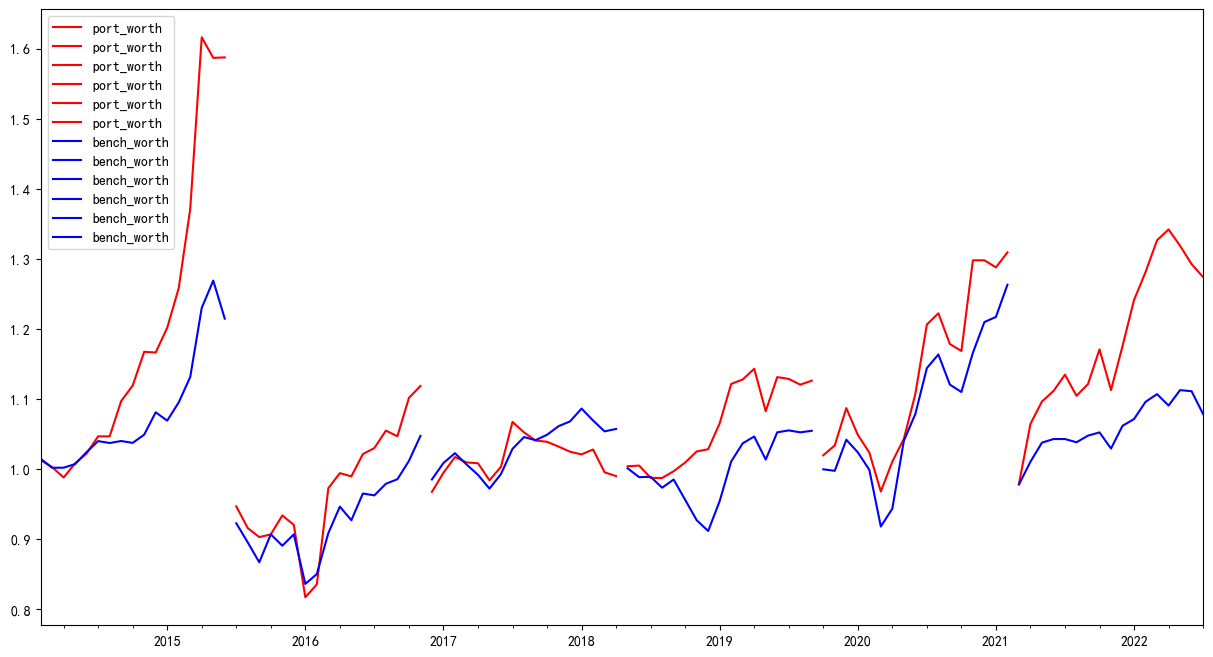

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in port_ws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in bench_ws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [12]:
con_pws = ev.get_continue_worth(port_ws)
con_bws = ev.get_continue_worth(bench_ws)

[]

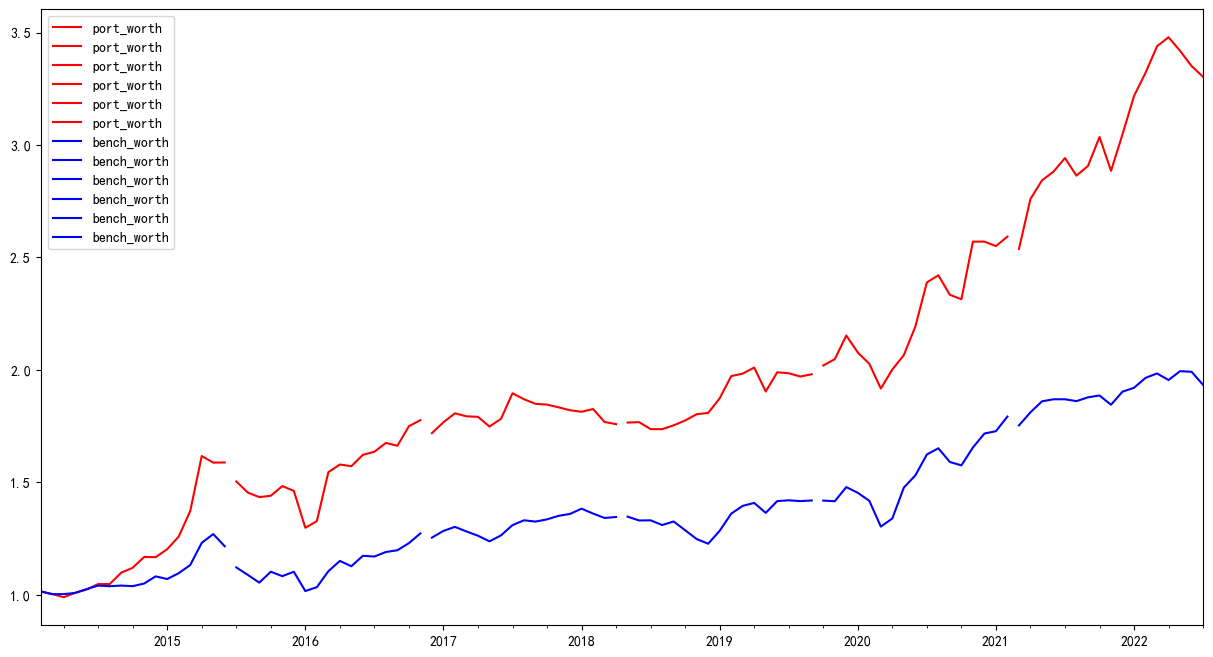

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
for pw in con_pws:
    pw.columns = ['port_worth']
    pw.plot.line(ax=ax, color='r')
for bw in con_bws:
    bw.columns = ['bench_worth']
    bw.plot(ax=ax, color='b')

ax.plot()

In [14]:
# 宏观因子重要性分析

In [15]:
keys = list(models_list.keys())
keys

['2014-01', '2015-06', '2016-11', '2018-04', '2019-09', '2021-02']

In [16]:
from utils_eda import get_ori_id, get_info, get_ori_name
asset_num = 9
asset_id = get_ori_id(y.columns[asset_num])
asset_name = get_ori_name(asset_id, get_info())
asset_name

'期货结算价(连续):WTI原油'

In [17]:
# 用feature_importances_或coef_取决于estimator
# values=models_list[keys[0]][asset_num][-1][-1].feature_importances_
values=models_list[keys[0]][asset_num][-1][-1].coef_
print(len(values))
names=models_list[keys[0]][asset_num][:-1].get_feature_names_out()
# names = [names[i].split('__')[-1] for i in range(len(names))]
print(len(names))
len(set(names))

3
92


92

In [18]:
# 查看单个时间段
# values=models_list['2018-03'][asset_num][-1][-1].feature_importances_
# names=models_list['2018-03'][asset_num][:-1].get_feature_names_out()
# names = [names[i].split('__')[-1] for i in range(len(names))]
# fea_imp = pd.DataFrame([names, values], index=['names', 'values'])
# fea_imp.sort_values(by='values', axis=1, ascending=False)

In [19]:
# 多个时间段整合
fi_df = pd.DataFrame(values, index=names, columns=[keys[0]])
fi_df = fi_df[~fi_df.index.duplicated()]
for i in range(1, len(keys)):
    values=models_list[keys[i]][asset_num][-1][-1].feature_importances_
    names=models_list[keys[i]][asset_num][:-1].get_feature_names_out()
    names = [names[i].split('__')[-1] for i in range(len(names))]
    fi = pd.DataFrame(values, index=names, columns=[keys[i]])
    fi = fi[~fi.index.duplicated()]
    fi_df = pd.concat([fi_df, fi], axis=1)
fi_df

ValueError: Shape of passed values is (3, 109), indices imply (92, 1)

In [ ]:
# 统计各指标在不同时期出现次数、重要性加和再排序
fi_df.apply(lambda x: x.sum(), axis=1).sort_values(ascending=False)[:10]

In [ ]:
fi_df.count(axis=1).sort_values(ascending=False)

In [ ]:
# 仓位分析
# 怎么又是熟悉的bug。pycahrm里是没问题的。
# 重新run一遍test，再跑。
# sb notebook的问题

In [20]:
port_positions = [utils_eda.trans_columns_name(i) for i in port_poss]

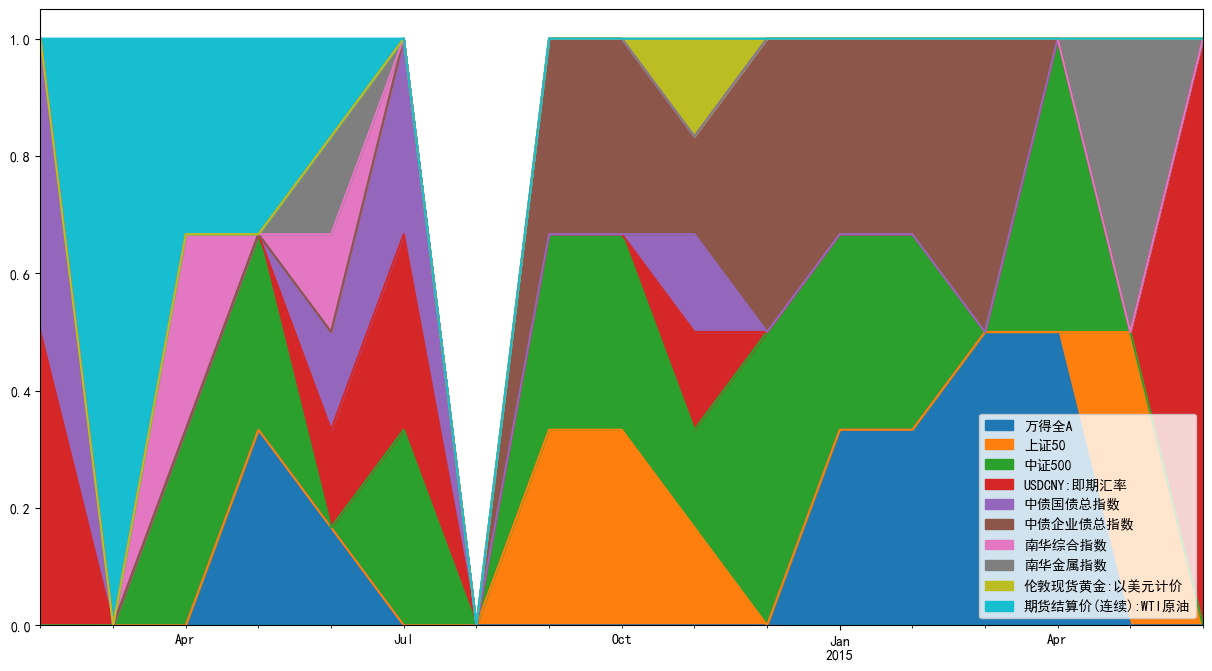

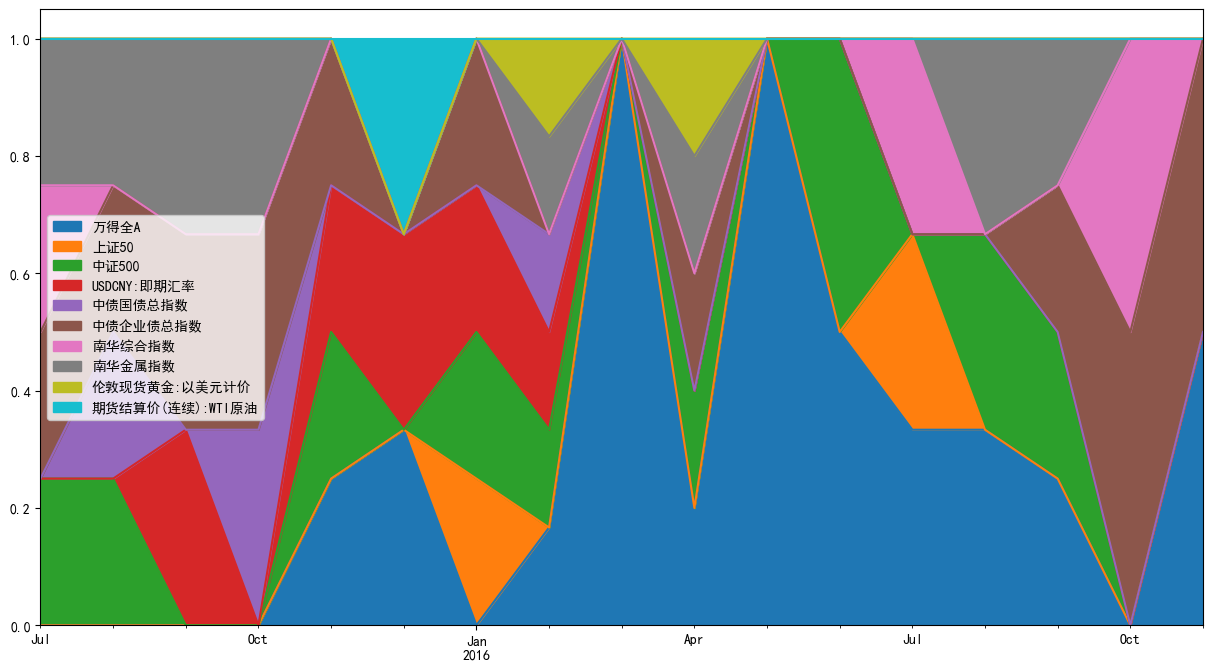

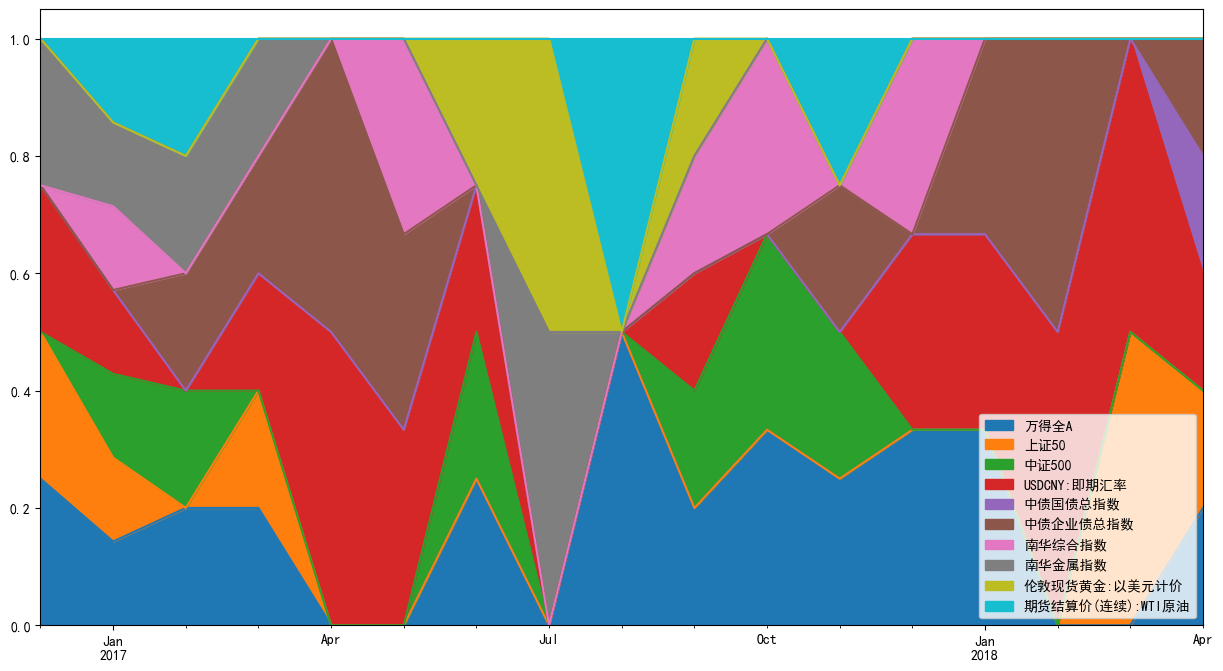

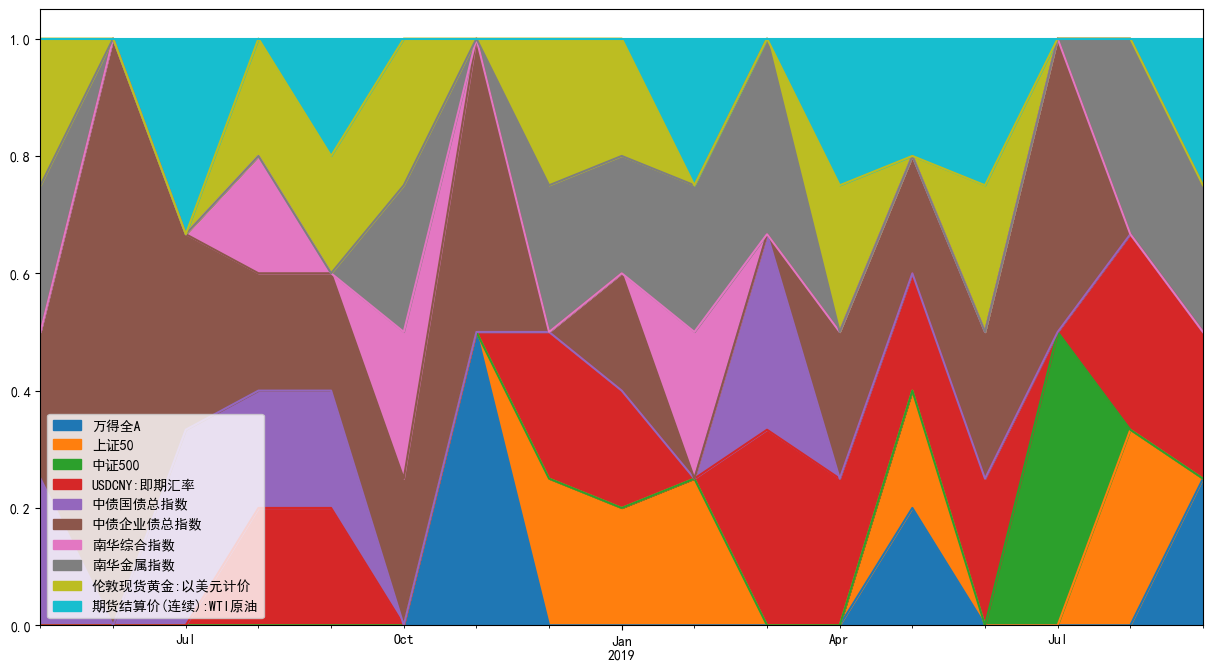

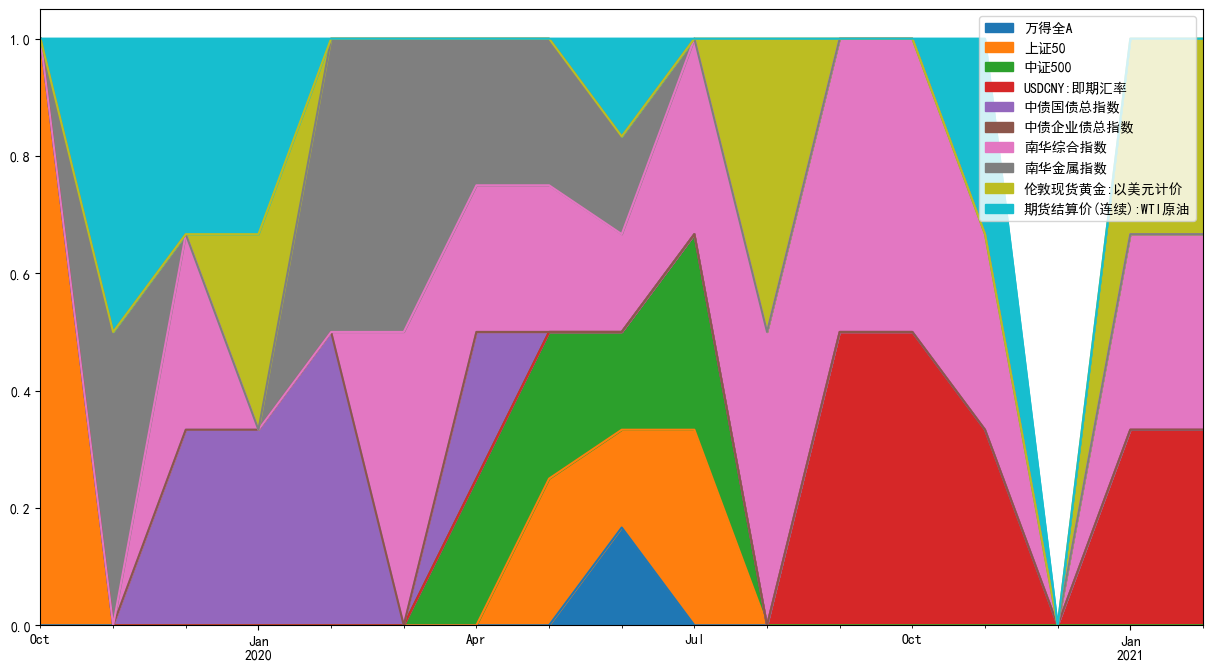

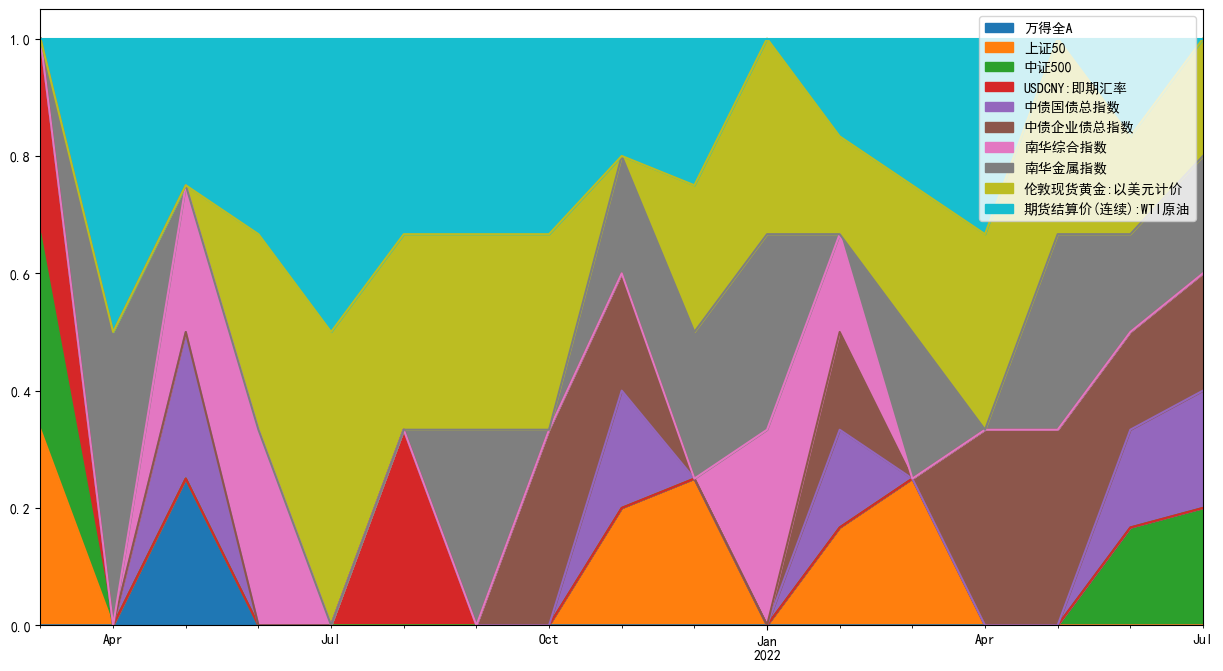

In [21]:
for i in range(len(port_poss)):
    port_positions[i].plot(kind='area',figsize=(15, 8))